# Import

In [1]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn, optim

from sklearn.metrics import log_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 드라이브 -> 코랩으로 이미지 로드하는 속도가 느려서 학습 속도가 느려짐
# /content/dataset에 이미지를 저장하면 빨라질 것으로 예상됨
import zipfile

zip_file_name = '/content/drive/MyDrive/Colab Notebooks/HAI-Hecto-AI-Challenge-2025/data.zip'
extraction_dir = '/content/dataset'

# 압축 해제
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# Hyperparameter Setting

In [4]:
CFG = {
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 10,
    'LEARNING_RATE': 1e-4,
    'SEED' : 42
}

# Fixed RandomSeed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

# CustomDataset

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        self.samples = []

        if is_test:
            # 테스트셋: 라벨 없이 이미지 경로만 저장
            for fname in sorted(os.listdir(root_dir)):
                if fname.lower().endswith(('.jpg')):
                    img_path = os.path.join(root_dir, fname)
                    self.samples.append((img_path,))
        else:
            # 학습셋: 클래스별 폴더 구조에서 라벨 추출
            self.classes = sorted(os.listdir(root_dir))
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

            for cls_name in self.classes:
                cls_folder = os.path.join(root_dir, cls_name)
                for fname in os.listdir(cls_folder):
                    if fname.lower().endswith(('.jpg')):
                        img_path = os.path.join(cls_folder, fname)
                        label = self.class_to_idx[cls_name]
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if self.is_test:
            img_path = self.samples[idx][0]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image
        else:
            img_path, label = self.samples[idx]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label


# Data Load

In [7]:
train_root = '/content/dataset/data/train'
test_root = '/content/dataset/data/test'

## 데이터셋 정규화를 위한 mean, std 산출

In [ ]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in tqdm(dataset)])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in tqdm(dataset)])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()

    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [47]:
transform = transforms.Compose([transforms.ToTensor()])
full_dataset_ = CustomImageDataset(train_root, transform=transform)

mean_, std_ = calculate_norm(full_dataset_)

(np.float32(0.42828095), np.float32(0.42260852), np.float32(0.4361709)) (np.float32(0.32236168), np.float32(0.32402048), np.float32(0.32310665))


## transform 규정

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.42828095, 0.42260852, 0.4361709],
                         std=[0.32236168, 0.32402048, 0.32310665])
])

val_transform = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.42828095, 0.42260852, 0.4361709],
                         std=[0.32236168, 0.32402048, 0.32310665])
])

In [9]:
# 전체 데이터셋 로드
full_dataset = CustomImageDataset(train_root, transform=None)
print(f"총 이미지 수: {len(full_dataset)}")

targets = [label for _, label in full_dataset.samples]
class_names = full_dataset.classes

# Stratified Split
train_idx, val_idx = train_test_split(
    range(len(targets)), test_size=0.2, stratify=targets, random_state=42
)

# Subset + transform 각각 적용
train_dataset = Subset(CustomImageDataset(train_root, transform=train_transform), train_idx)
val_dataset = Subset(CustomImageDataset(train_root, transform=val_transform), val_idx)
print(f'train 이미지 수: {len(train_dataset)}, valid 이미지 수: {len(val_dataset)}')


# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

총 이미지 수: 33114
train 이미지 수: 26491, valid 이미지 수: 6623


## 데이터셋 예시

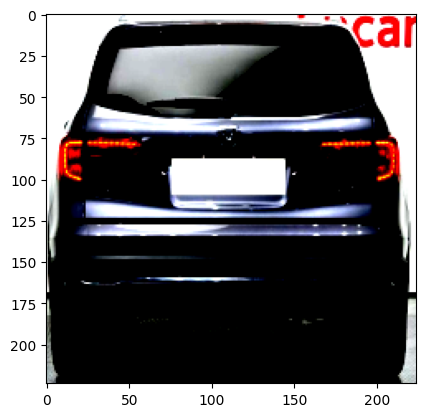

In [54]:
import matplotlib.pyplot as plt
import itertools as it
import cv2

def toimage(target):
  C, H, W = target.shape
  res = np.zeros((H, W, C))
  for h, w, c in it.product(range(H), range(W), range(C)):
    res[h][w][c] = target[c][h][w]
  return res

image, _ = train_dataset[np.random.randint(0, len(train_dataset)-1)]
image = toimage(image)
plt.imshow(image)

# Model Define

In [10]:
class PT_resnet50(nn.Module):
    def __init__(self, num_classes):
        super(PT_resnet50, self).__init__()
        # self.backbone = models.resnet18(pretrained=True)
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT) # pretrained Resnet50
        self.feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # feature extractor로만 사용
        self.head = nn.Linear(self.feature_dim, num_classes)  # 분류기

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

# Train/ Validation

In [11]:
# record model accuracy
import matplotlib.pyplot as plt
import seaborn as sns

val_acc_history = []
train_loss_history = []
val_loss_history = []

## First time

In [12]:
model = PT_resnet50(num_classes=len(class_names)).to(device)
best_logloss = float('inf')

print('[Execute Model Training on {}]'.format(device))

# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저
optimizer = optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])

# 학습 및 검증 루프
for epoch in range(CFG['EPOCHS']):
    # Train
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{CFG['EPOCHS']}] Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)  # logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"[Epoch {epoch+1}/{CFG['EPOCHS']}] Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # LogLoss
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_logloss = log_loss(all_labels, all_probs, labels=list(range(len(class_names))))

    train_loss_history.append(avg_train_loss)
    val_acc_history.append(val_accuracy)
    val_loss_history.append(val_logloss)

    # 결과 출력
    print(f"Train Loss : {avg_train_loss:.4f} || Valid Loss : {avg_val_loss:.4f} | Valid Accuracy : {val_accuracy:.4f}%")

    # Best model 저장
    # if val_logloss < best_logloss:
    # best_logloss = val_logloss
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/HAI-Hecto-AI-Challenge-2025/models/resnet50/epoch{epoch+1}_loss{val_logloss}_model.pth')
    print(f"📦 Best model saved at epoch {epoch+1} (logloss: {val_logloss:.4f})")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


[Execute Model Training on cuda]


[Epoch 1/10] Validation: 100%|██████████| 104/104 [01:03<00:00,  1.63it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 3.3590 || Valid Loss : 0.8552 | Valid Accuracy : 79.7524%
📦 Best model saved at epoch 1 (logloss: 0.8548)


[Epoch 2/10] Validation: 100%|██████████| 104/104 [01:00<00:00,  1.73it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.4650 || Valid Loss : 0.3473 | Valid Accuracy : 89.6724%
📦 Best model saved at epoch 2 (logloss: 0.3466)


[Epoch 3/10] Validation: 100%|██████████| 104/104 [00:59<00:00,  1.75it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.1501 || Valid Loss : 0.2696 | Valid Accuracy : 92.1637%
📦 Best model saved at epoch 3 (logloss: 0.2690)


[Epoch 4/10] Validation: 100%|██████████| 104/104 [01:00<00:00,  1.73it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0760 || Valid Loss : 0.2423 | Valid Accuracy : 92.6166%
📦 Best model saved at epoch 4 (logloss: 0.2415)


[Epoch 5/10] Validation: 100%|██████████| 104/104 [00:59<00:00,  1.75it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0411 || Valid Loss : 0.2337 | Valid Accuracy : 93.4471%
📦 Best model saved at epoch 5 (logloss: 0.2332)


[Epoch 6/10] Validation: 100%|██████████| 104/104 [01:00<00:00,  1.72it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0264 || Valid Loss : 0.2455 | Valid Accuracy : 93.5981%


[Epoch 7/10] Validation: 100%|██████████| 104/104 [00:58<00:00,  1.78it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0220 || Valid Loss : 0.2608 | Valid Accuracy : 93.5528%


[Epoch 8/10] Validation: 100%|██████████| 104/104 [00:59<00:00,  1.75it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0288 || Valid Loss : 0.5246 | Valid Accuracy : 86.7885%


[Epoch 9/10] Validation: 100%|██████████| 104/104 [01:00<00:00,  1.72it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Train Loss : 0.0731 || Valid Loss : 0.3068 | Valid Accuracy : 92.2392%


[Epoch 10/10] Validation: 100%|██████████| 104/104 [01:03<00:00,  1.64it/s]

Train Loss : 0.0226 || Valid Loss : 0.2443 | Valid Accuracy : 93.8547%



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


## load pth, train

In [ ]:
model = PT_resnet50(num_classes=len(class_names)).to(device)
best_logloss = float('inf')

print('[Execute Model Training on {}]'.format(device))

# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저
optimizer = optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])

# 학습 및 검증 루프
for epoch in range(CFG['EPOCHS']):
    # Train
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{CFG['EPOCHS']}] Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)  # logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"[Epoch {epoch+1}/{CFG['EPOCHS']}] Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # LogLoss
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_logloss = log_loss(all_labels, all_probs, labels=list(range(len(class_names))))

    train_loss_history.append(avg_train_loss)
    val_acc_history.append(val_accuracy)
    val_loss_history.append(val_logloss)

    # 결과 출력
    print(f"Train Loss : {avg_train_loss:.4f} || Valid Loss : {avg_val_loss:.4f} | Valid Accuracy : {val_accuracy:.4f}%")

    # Best model 저장
    if val_logloss < best_logloss:
        best_logloss = val_logloss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/HAI-Hecto-AI-Challenge-2025/RenewedData_Baseline_model.pth')
        print(f"📦 Best model saved at epoch {epoch+1} (logloss: {val_logloss:.4f})")

## Plot Acc, Loss

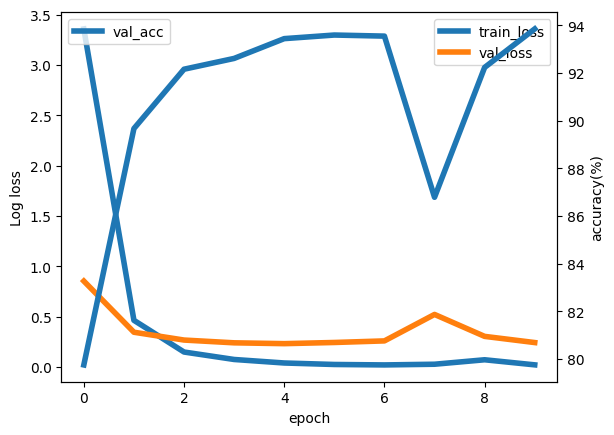

In [13]:
# plot model accuracy
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()

ax1 = fig.add_subplot(1, 1, 1)
sns.set_palette('tab10')
chart1 = sns.lineplot(x=range(len(train_loss_history)), y=train_loss_history, label='train_loss', linewidth=4)
chart3 = sns.lineplot(x=range(len(val_loss_history)), y=val_loss_history, label='val_loss', linewidth=4)
ax1.set_ylabel('Log loss')
ax1.set_xlabel('epoch')
plt.legend()

ax2 = ax1.twinx()
chart2 = sns.lineplot(x=range(len(val_acc_history)), y=val_acc_history, label='val_acc', linewidth=4)
ax2.set_ylabel('accuracy(%)')
plt.legend()



# Inference

In [15]:
test_dataset = CustomImageDataset(test_root, transform=val_transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

In [16]:
# 저장된 모델 로드
model = PT_resnet50(num_classes=len(class_names))
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/HAI-Hecto-AI-Challenge-2025/models/resnet50/epoch5_loss0.2332.pth', map_location=device))
model.to(device)

# 추론
model.eval()
results = []

with torch.no_grad():
    for images in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)

        # 각 배치의 확률을 리스트로 변환
        for prob in probs.cpu():  # prob: (num_classes,)
            result = {
                class_names[i]: prob[i].item()
                for i in range(len(class_names))
            }
            results.append(result)

pred = pd.DataFrame(results)

# Submission

In [17]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HAI-Hecto-AI-Challenge-2025/submission/sample_submission.csv', encoding='utf-8-sig')

# 'ID' 컬럼을 제외한 클래스 컬럼 정렬
class_columns = submission.columns[1:]
pred = pred[class_columns]

submission[class_columns] = pred.values
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/HAI-Hecto-AI-Challenge-2025/submission/epoch5_loss0.2332.csv', index=False, encoding='utf-8-sig')

In [18]:
import shutil
shutil.rmtree('/content/drive/MyDrive/Colab Notebooks/HAI-Hecto-AI-Challenge-2025/fromDataloader')